In [1]:
'''
Throughout this book, we will often work with text data represented as sequences of words, characters, or word pieces. 
To get going, we will need some basic tools for converting raw text into sequences of the appropriate form. 
Typical preprocessing pipelines execute the following steps:

1. Load text as strings into memory.

2. Split the strings into tokens (e.g., words or characters).

3. Build a vocabulary dictionary to associate each vocabulary element with a numerical index.

4. Convert the text into sequences of numerical indices.
'''
import collections
import random
import re
import torch
from d2l import torch as d2l

In [2]:
# Reading the Dataset
class TimeMachine(d2l.DataModule):  # @save
    """The Time Machine dataset."""

    def _download(self):
        fname = d2l.download(d2l.DATA_URL + 'timemachine.txt', self.root,
                             '090b5e7e70c295757f55df93cb0a180b9691891a')
        with open(fname) as f:
            return f.read()


data = TimeMachine()
raw_text = data._download()
raw_text[:60]

'The Time Machine, by H. G. Wells [1898]\n\n\n\n\nI\n\n\nThe Time Tra'

In [5]:
print(len(raw_text))

178979


In [6]:
@d2l.add_to_class(TimeMachine)  # @save
def _preprocess(self, text):
    return re.sub('[^A-Za-z]+', ' ', text).lower()


text = data._preprocess(raw_text)
text[:60]

'the time machine by h g wells i the time traveller for so it'

In [7]:
print(len(text))

173428


In [14]:
# Tokenization 
@d2l.add_to_class(TimeMachine)  # @save
def _tokenize(self, text):
    return list(text)


tokens = data._tokenize(text)
# tokens[:300]
','.join(tokens[:30])

't,h,e, ,t,i,m,e, ,m,a,c,h,i,n,e, ,b,y, ,h, ,g, ,w,e,l,l,s, '

In [12]:
print(len(tokens))

173428


In [15]:
# Vocabulary 
class Vocab:  # @save
    """Vocabulary for text."""

    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # Count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']

In [16]:
vocab = Vocab(tokens)  # 传入了一个list，长度目前是173428
indices = vocab[tokens[:10]]
print('indices:', indices)
print('words:', vocab.to_tokens(indices))

‘’‘ 
`Vocab` 类中定义了一些特殊方法，使得它可以像列表一样使用。具体来说，它实现了 `__getitem__` 和 `__len__` 方法。这些方法在Python中被称为魔法方法或运算符重载，它们允许程序员自定义类的行为，使其在特定情况下表现得像内置类型（如列表、字典等）。

1. `__getitem__(self, tokens)` 方法允许您使用索引或键访问类的元素。在这个例子中，`__getitem__` 方法接受一个 token（可以是单个 token 或 token 列表）并返回相应的索引。当您使用 `vocab[tokens[:10]]` 时，实际上调用了 `__getitem__` 方法。

2. `__len__(self)` 方法允许您使用 `len()` 函数获取类的长度。在这个例子中，`__len__` 方法返回 `idx_to_token` 列表的长度，即词汇表中唯一 token 的数量。

由于 `Vocab` 类实现了这些方法，您可以像使用列表一样使用它。但请注意，`Vocab` 类并不是真正的列表，而是一个自定义类，它实现了特定的方法，使其在某些方面表现得像列表。
’‘’

indices: [21, 9, 6, 0, 21, 10, 14, 6, 0, 14]
words: ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm']


In [17]:
# Putting It All Together
@d2l.add_to_class(TimeMachine)  # @save
def build(self, raw_text, vocab=None):
    tokens = self._tokenize(self._preprocess(raw_text))
    if vocab is None:
        vocab = Vocab(tokens)
    corpus = [vocab[token] for token in tokens]
    return corpus, vocab


corpus, vocab = data.build(raw_text)
len(corpus), len(vocab)

(173428, 28)

In [21]:
print(vocab.idx_to_token)

[' ', '<unk>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [22]:
for token, idx in vocab.token_to_idx.items():
    print(f"Token: {token}, Index: {idx}")

Token:  , Index: 0
Token: <unk>, Index: 1
Token: a, Index: 2
Token: b, Index: 3
Token: c, Index: 4
Token: d, Index: 5
Token: e, Index: 6
Token: f, Index: 7
Token: g, Index: 8
Token: h, Index: 9
Token: i, Index: 10
Token: j, Index: 11
Token: k, Index: 12
Token: l, Index: 13
Token: m, Index: 14
Token: n, Index: 15
Token: o, Index: 16
Token: p, Index: 17
Token: q, Index: 18
Token: r, Index: 19
Token: s, Index: 20
Token: t, Index: 21
Token: u, Index: 22
Token: v, Index: 23
Token: w, Index: 24
Token: x, Index: 25
Token: y, Index: 26
Token: z, Index: 27


In [23]:
# Exploratory Language Statistics
words = text.split()
vocab = Vocab(words)
vocab.token_freqs[:10]

''' 
词的分布通常遵循齐夫定律（Zipf's Law），这是一种描述自然语言中词频分布的经验定律。齐夫定律指出，一个文本中的任何词的频率与它在频率排序中的排名成反比。具体来说，最常见的词（排名第一）的频率大约是第二常见词的两倍，是第三常见词的三倍，以此类推。

这种分布的原因尚未完全清楚，但有几种理论解释。一种解释是，语言的使用者倾向于最小化他们的沟通努力，因此会频繁使用一小部分词汇。另一种解释是，语言的使用者倾向于保持他们的词汇使用的多样性，因此会不时地使用一些较少见的词汇。这两种倾向导致了词频的齐夫分布。

无论原因是什么，齐夫定律为自然语言处理提供了有用的信息。例如，由于大多数词汇都很少见，因此在处理文本数据时，处理稀疏性问题（如未知词汇）就变得非常重要。此外，由于少数词汇的频率极高，因此优化这些词汇的处理也很重要，例如通过使用停用词列表或子词编码。
'''

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

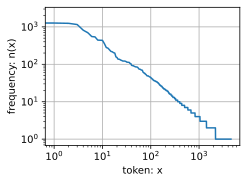

In [24]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log')

In [27]:
print(len(freqs))

4579


In [28]:
bigram_tokens = ['--'.join(pair) for pair in zip(words[:-1], words[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

''' 
在 Python 中，列表的切片操作可以用来获取列表的一部分。`words[:-1]` 和 `words[1:]` 是两种切片操作。

- `words[:-1]` 表示获取列表 `words` 从第一个元素开始到倒数第二个元素的所有元素。`-1` 表示倒数第一个元素，所以 `:-1` 就表示从开始到倒数第一个元素之前（不包括倒数第一个元素）。

- `words[1:]` 表示获取列表 `words` 从第二个元素开始到最后一个元素的所有元素。在切片操作中，如果省略了结束位置，就会一直切片到列表的末尾。

因此，`words[:-1]` 和 `words[1:]` 实际上是创建了两个新的列表，它们分别包含了 `words` 中的元素，但是一个比另一个分别少了第一个和最后一个元素。这样做的目的是为了配对每个单词和它后面的单词。
'''

[('of--the', 309),
 ('in--the', 169),
 ('i--had', 130),
 ('i--was', 112),
 ('and--the', 109),
 ('the--time', 102),
 ('it--was', 99),
 ('to--the', 85),
 ('as--i', 78),
 ('of--a', 73)]

在 Python 中，`zip()` 函数将多个可迭代对象（如列表）中的元素一一配对。在这个例子中，`zip(words[:-1], words[1:])` 会将 `words` 列表中的每个单词与它后面的单词配对。然后，列表推导式 `['--'.join(pair) for pair in zip(words[:-1], words[1:])]` 将这些配对的单词连接起来，中间用 `--` 分隔。

在 Go 语言中，可以通过以下代码实现类似的功能：

```go
package main

import (
	"fmt"
	"strings"
)

func main() {
	words := []string{"I", "am", "a", "student"}
	bigramTokens := make([]string, len(words)-1)

	for i := 0; i < len(words)-1; i++ {
		bigramTokens[i] = strings.Join([]string{words[i], words[i+1]}, "--")
	}

	fmt.Println(bigramTokens)
}
```

这段 Go 代码首先创建一个新的切片 `bigramTokens`，其长度为 `len(words) - 1`。然后，通过遍历 `words` 切片中的每个元素（除了最后一个），并将它与后面的元素连接起来，中间用 `--` 分隔。最后，将结果存储在 `bigramTokens` 切片中。

In [29]:
trigram_tokens = ['--'.join(triple) for triple in zip(
    words[:-2], words[1:-1], words[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[('the--time--traveller', 59),
 ('the--time--machine', 30),
 ('the--medical--man', 24),
 ('it--seemed--to', 16),
 ('it--was--a', 15),
 ('here--and--there', 15),
 ('seemed--to--me', 14),
 ('i--did--not', 14),
 ('i--saw--the', 13),
 ('i--began--to', 13)]

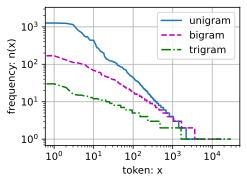

In [30]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

这段文字讨论了 n-gram（词组）在自然语言中的分布特点。n-gram 是指由 n 个连续的词组成的序列。在这里，作者发现 n-gram 的分布也遵循 Zipf's Law，尽管指数较小。这个发现有以下几个重要的启示：

1. 除了单个词（unigram）之外，词组（n-gram）的分布也遵循 Zipf's Law。这表明自然语言中的结构不仅存在于单个词的层面，还存在于词组的层面。

2. 不同的 n-gram 数量并不是很大。这意味着语言中存在相当多的结构，这有助于我们从大量文本中学习模式和规律。

3. 很多 n-gram 出现的频率非常低。这使得某些方法不适用于语言建模，因为它们难以处理低频的 n-gram。这也激发了使用深度学习模型进行自然语言处理的需求，因为深度学习模型能够更好地处理稀疏性问题。

在接下来的部分，作者将讨论如何使用深度学习模型处理自然语言中的这些结构和分布特点。

文本是深度学习中最常见的序列数据形式之一。通常选择字符、单词和词片作为标记。在预处理文本时，通常需要执行以下步骤：(i) 将文本拆分为标记；(ii) 构建词汇表，将标记字符串映射到数值索引；(iii) 将文本数据转换为模型可以操作的标记索引。实际上，词频往往遵循齐夫定律（Zipf's Law）。这不仅适用于单个单词（unigrams），还适用于 n-grams。

n-gram 是指由 n 个连续的词组成的序列。例如，bigrams（二元组）是由两个连续的词组成的序列，trigrams（三元组）是由三个连续的词组成的序列，依此类推。n-gram 的分布特点对于自然语言处理任务具有重要意义，因为它们揭示了文本中的结构和模式。

在实际应用中，深度学习模型通常需要处理不同长度的序列，而 n-gram 可以帮助模型捕捉局部上下文信息。此外，由于许多 n-gram 出现的频率较低，因此深度学习模型需要能够处理稀疏性问题。这就需要在模型设计和训练方法上进行创新，以便更好地处理自然语言中的这些特点。

1. 如何改变 `min_freq` 参数值影响词汇表大小？

`min_freq` 参数用于设置词汇表中单词的最小频率。只有当单词的频率大于或等于 `min_freq` 时，它才会被包含在词汇表中。增加 `min_freq` 的值会减少词汇表中的单词数量，因为只有较高频率的单词才会被保留。相反，降低 `min_freq` 的值会增加词汇表中的单词数量，因为更多的低频单词会被包含进来。在实际应用中，可以根据任务需求和计算资源来调整 `min_freq` 的值，以平衡词汇表的大小和模型的性能。

2. 估计齐夫定律的指数

为了估计 unigrams、bigrams 和 trigrams 的齐夫定律指数，首先需要计算它们的频率分布。然后，可以使用最小二乘法或其他拟合方法拟合这些分布，以获得指数。具体来说，可以将词频与排名的关系表示为 y = a * x^(-b)，其中 x 是排名，y 是词频，a 和 b 是参数。对这个方程取对数后，可以得到 log(y) = log(a) - b * log(x)。这是一个线性方程，可以使用线性回归方法求解。拟合后得到的 b 值就是齐夫定律的指数。

3. 使用其他数据源进行比较

为了回答这个问题，你需要选择其他数据源（如标准机器学习数据集、另一本公共领域图书、网站抓取的数据等），然后在单词和字符级别进行标记化。接下来，比较这些数据源与《时间机器》语料库在相同 `min_freq` 值下的词汇表大小。此外，还需要估计这些语料库的 unigram 和 bigram 分布对应的齐夫定律指数。最后，将这些指数与《时间机器》语料库的指数进行比较。这将帮助你了解不同数据源之间的分布特点以及它们与《时间机器》语料库的相似性和差异性。